In [74]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from hmmlearn import hmm

In [79]:
def create_graph():
    # Create a 10x10 grid graph
    G = nx.grid_2d_graph(10, 10)

    # Assign (x, y) as a property of each node
    for node in G.nodes():
        G.nodes[node]['pos'] = node  # Storing position as a property

    # # Draw the graph with labels
    # plt.figure(figsize=(8, 8))
    # pos = {node: (node[0], node[1]) for node in G.nodes()} 
    # nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color='gray')
    # plt.show()
    
    return G

In [68]:
def generate_random_walks(epsilon, num_points):
    G = create_graph()
    
    # Generate random starting point
    random_node = random.choice(list(G.nodes()))
    print(f"Start node: {random_node}")
    
    epsilon_x = np.random.normal(0, np.sqrt(epsilon))
    epsilon_y = np.random.normal(0, np.sqrt(epsilon))
    first_noisy_point = (random_node[0] + epsilon_x, random_node[1] + epsilon_y)

    actual_points = [random_node]
    trajectory = [first_noisy_point]
    
    # Generate a random walk and associated noisy points
    for _ in range(num_points - 1):
        node = actual_points[-1]
        
        # Get a random neighbor
        neighbors = list(G.neighbors(node))  
        rand_neighbor = random.choice(neighbors)
        
        epsilon_x = np.random.normal(0, np.sqrt(epsilon))
        epsilon_y = np.random.normal(0, np.sqrt(epsilon))
        noisy_point = (rand_neighbor[0] + epsilon_x, rand_neighbor[1] + epsilon_y)
        
        actual_points.append(rand_neighbor)
        trajectory.append(noisy_point)

    return actual_points, trajectory
        

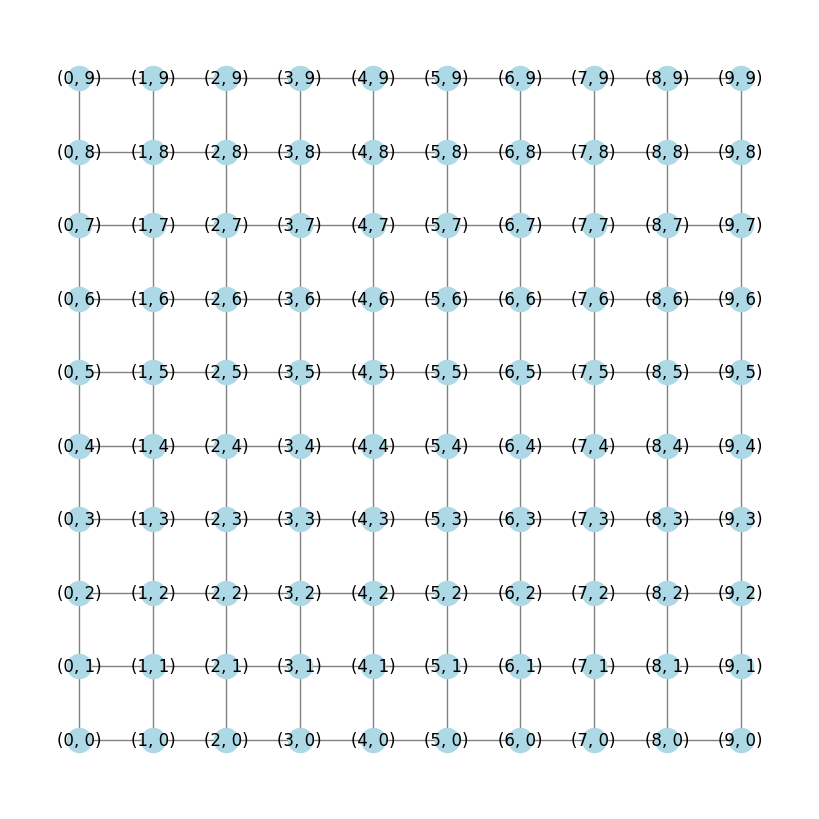

Start node: (5, 1)
[(5, 1), (5, 0), (4, 0), (5, 0), (5, 1)]
[(5.047095771204762, 1.0690428462735146), (5.479805087176561, -0.5059566084741621), (3.587311300959862, 0.45501273079666177), (5.10138335051578, 0.05664858262442071), (5.111231633377226, 0.22668898950575844)]


In [72]:
actual_points, trajectory = generate_random_walks(0.1, 5)
print(actual_points)
print(trajectory)

In [75]:
def build_hmm(G, epsilon):
    """Creates an HMM where states are nodes (x, y) and observations are noisy positions."""
    states = list(G.nodes())  # All nodes as states
    n_states = len(states)

    # Transition matrix (uniform probability among neighbors)
    transition_matrix = np.zeros((n_states, n_states))
    for i, node in enumerate(states):
        neighbors = list(G.neighbors(node))
        if neighbors:
            for neighbor in neighbors:
                j = states.index(neighbor)
                transition_matrix[i, j] = 1 / len(neighbors)

    # Emission model (Gaussian noise around true position)
    means = np.array(states)  # True positions as means
    covars = np.full((n_states, 2, 2), np.eye(2) * epsilon)  # Covariance = epsilon * Identity

    # Define HMM
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100)
    model.startprob_ = np.full(n_states, 1 / n_states)  # Uniform start probability
    model.transmat_ = transition_matrix  # Transition matrix
    model.means_ = means  # Means (true positions)
    model.covars_ = covars  # Covariance (Gaussian noise)

    return model, states

In [76]:
def train_and_predict(G, epsilon, actual_points, noisy_observations):
    """Fits HMM to noisy trajectory and predicts the true path."""
    model, states = build_hmm(G, epsilon)
    
    # Convert observations to HMM format
    obs = np.array(noisy_observations)

    # Fit and predict most likely hidden states
    predicted_indices = model.predict(obs)
    predicted_states = [states[i] for i in predicted_indices]

    return predicted_states

In [77]:
def evaluate_accuracy(true_states, predicted_states):
    """Computes accuracy as the fraction of correctly predicted states."""
    correct = sum(t == p for t, p in zip(true_states, predicted_states))
    return correct / len(true_states)

Noise level: 0.1
Start node: (1, 3)
True states: [(1, 3), (0, 3), (0, 2), (1, 2), (1, 3), (1, 4), (2, 4), (3, 4), (2, 4), (2, 3), (2, 2), (1, 2), (2, 2), (3, 2), (3, 1), (2, 1), (1, 1), (1, 0), (0, 0), (0, 1), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (2, 3), (3, 3), (3, 2)]
Noisy states: [(0.9075979199224425, 2.6491873765207985), (-0.09920849539420203, 3.1595020946276486), (-0.034543769197271076, 1.8781689040419787), (1.451551726388982, 2.7193345048300013), (1.2963199551767486, 3.0342430580703215), (1.091589432360984, 3.977634436349885), (2.4360279809591825, 4.10507720760594), (2.9783997047975896, 4.52215476353717), (2.025886046250134, 3.737821733576642), (2.148045844284609, 2.921950517279366), (1.3255294783809393, 1.7896008644779664), (1.0503863760963597, 1.8796281082863757), (1.9548121808742507, 2.1120076550699047), (3.708690870155422, 2.187377498279417), (3.0691816703334824, 1.0085875276578034), (2.4620933714962425, 1.84120736309597), (0.7757303095328507, 1.0831799599

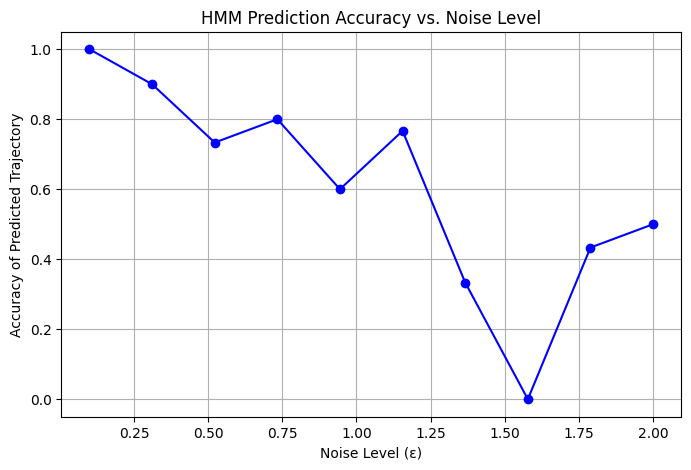

In [82]:
# Experiment: Vary epsilon and measure accuracy
epsilons = np.linspace(0.1, 2.0, 10)  # Different noise levels
accuracies = []

G = create_graph()  # Generate graph once

for epsilon in epsilons:
    print(f"Noise level: {epsilon}")
    true_states, noisy_obs = generate_random_walks(epsilon, num_points=30)
    print(f"True states: {true_states}")
    print(f"Noisy states: {noisy_obs}")
    predicted_states = train_and_predict(G, epsilon, true_states, noisy_obs)
    print(f"Predicted States: {predicted_states}")
    accuracy = evaluate_accuracy(true_states, predicted_states)
    accuracies.append(accuracy)

# Plot accuracy vs. noise level
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel("Noise Level (ε)")
plt.ylabel("Accuracy of Predicted Trajectory")
plt.title("HMM Prediction Accuracy vs. Noise Level")
plt.grid()